## **Working with netcdf data in R**

This notebook shows you how to read the provided climate data in R and produce some sample plots. In this example, we'll be loading and plotting variable `tas`, which is the daily mean temperature. To load a different variable, `tas` will need to be replaced throughout the code with the name of the variable you want to look at.

---


## **Reading data from netcdf**

First, load the required libraries.

In [2]:
library(ncdf4)                  # needed to read netcdf data
library(ncdf4.helpers)          # additional support functions for netcdf data
library(fields)                 # provides image.plot()
library(rgdal)                  # load shapefiles
library(abind)                  # join arrays together

Read data from the netcdf into R:

In [3]:
fnm <- "~/UKCP18/day/tas_rcp85_land-rcm_uk_12km_01_day_20201201-20301130.nc"

# open a connection to the netcdf file
nc <- nc_open(fnm)

# read the data into R
tas <- ncvar_get(nc, "tas")

# check the dimensions of your variable. Daily UKCP18 data is stored in arrays of 82 · 112 · 3600, where the dimensions are eastings · northings · date.
dim(tas)

[1]   82  112 3600

In [4]:
# label the dimensions of your array with the dimensions of the netcdf - this means that you can refer to them by E/N/date
dimnames(tas) <- list("E" = ncvar_get(nc, "projection_x_coordinate"),
                      "N" = ncvar_get(nc, "projection_y_coordinate"),
                      "date" = substr(nc.get.time.series(nc, "tas"),1,10))

# dates are stored as a date-time string: we're only really interested in the date, so we use 'substring' to extract the date only

head(dimnames(tas)$date); tail(dimnames(tas)$date)

[1] "2020-12-01" "2020-12-02" "2020-12-03" "2020-12-04" "2020-12-05"
[6] "2020-12-06"

[1] "2030-11-25" "2030-11-26" "2030-11-27" "2030-11-28" "2030-11-29"
[6] "2030-11-30"

In the UKCP18 data, climate years start in December, to coincide with the start of meteorological winter (Dec, Jan , Feb) and end in Nov, the end of meteorological autumn (Sep, Oct, Nov). Each 'month' in the data has 30 days. One decade of model output therefore contains 3600 daily values. **Because every month in the UKCP18 data has 30 days, packages like `lubridate` can't handle the dates - use substrings of the date to select dates instead!**

When you're finished, close and remove the connection to the netcdf:

In [5]:
nc_close(nc); remove(nc)

Now we have an array `tas` containing ten years of daily model output on an 82 by 112 grid, covering the UK.

---

## **Plot a map of the data**

The gridded data can be plotted quite easily using `image()`:

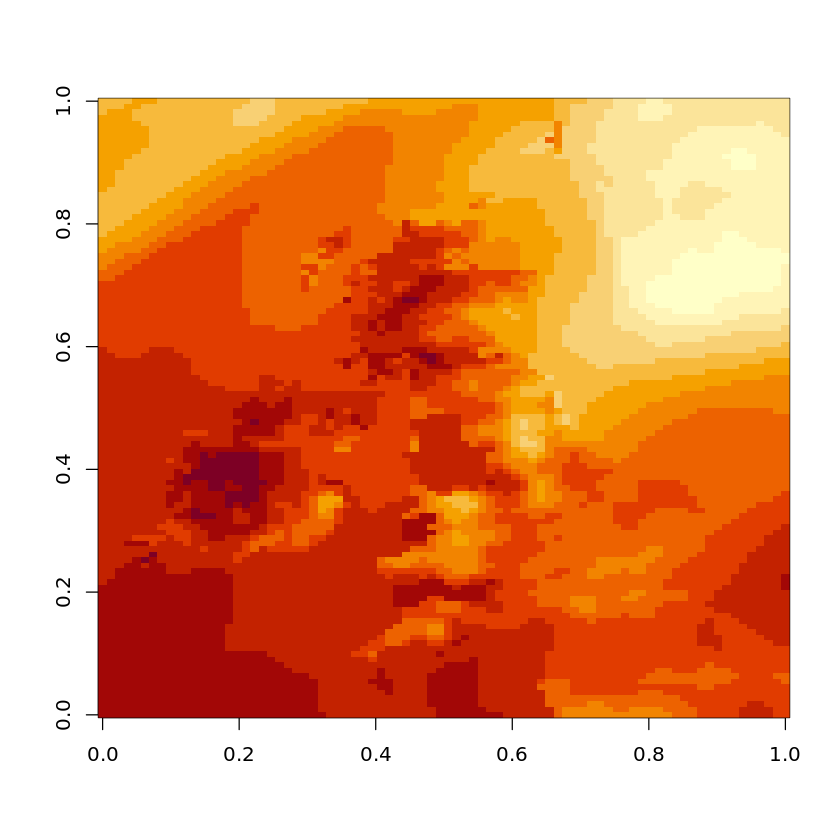

In [6]:
image(tas[,,"2021-06-01"])

But with a couple of minor tweaks, we can make this plot look a bit nicer:

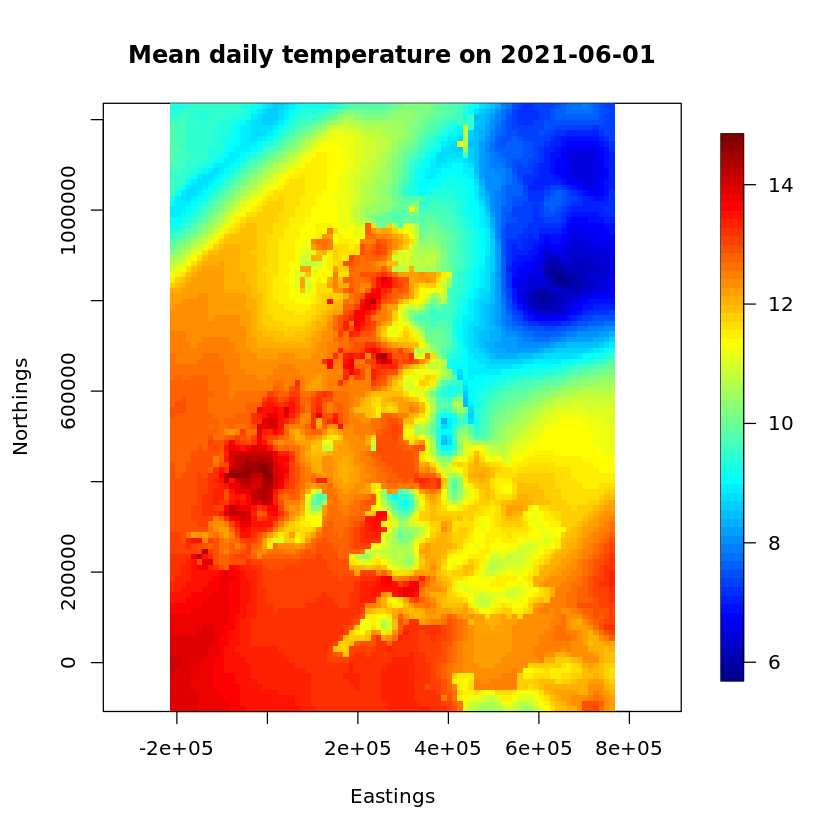

In [7]:
image.plot(x = as.integer(rownames(tas)), y = as.integer(colnames(tas)), tas[,,"2021-06-01"], asp = T, 
           xlab = "Eastings", ylab = "Northings", main = "Mean daily temperature on 2021-06-01")     

# image.plot adds a gradient scale
# adding x and y labels shows where we're looking, and makes it easier to add other layers like maps
# asp = T fixes the aspect ratio so that the grid cells are square

We can also add an outline map of the UK to our plot, using a shapefile.

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum OSGB_1936 in CRS definition: +proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +units=m +no_defs”


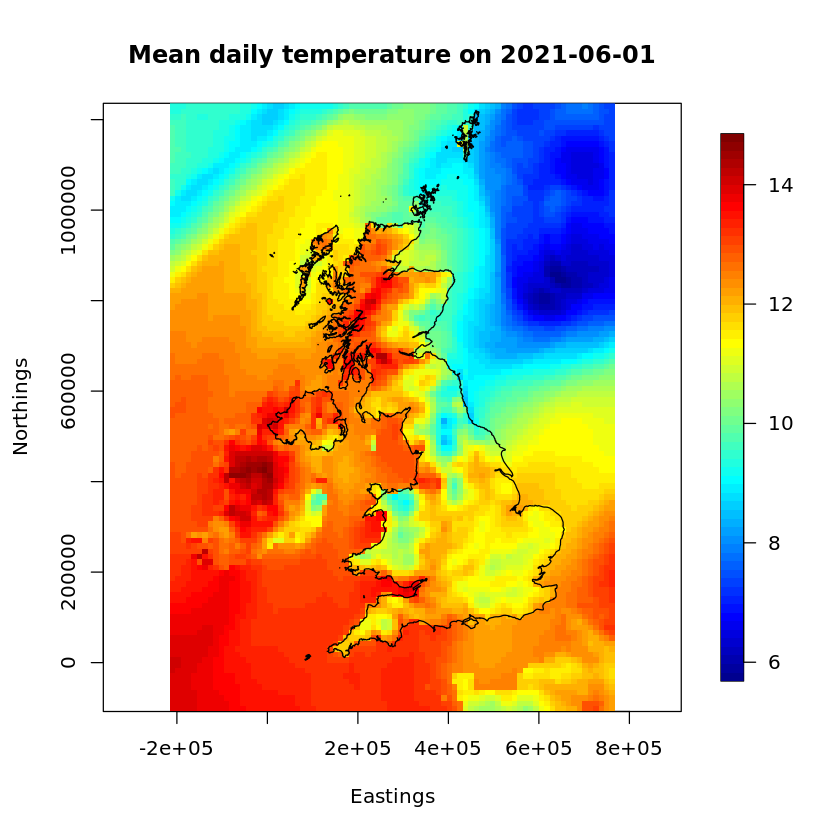

In [8]:
# load the shapefile - this will produce a warning message about a discarded datum, which you can safely ignore
osgbmap <- readOGR("~/UKCP18/ukcp-spatial-files/spatial-files/ukcp18-uk-land-country-united_kingdom-hires", verbose = F)

image.plot(x = as.integer(rownames(tas)), y = as.integer(colnames(tas)), tas[,,"2021-06-01"], asp = T, 
           xlab = "Eastings", ylab = "Northings", main = "Mean daily temperature on 2021-06-01")  
sp::plot(osgbmap, add = T)

---

## **Compute decadal means from daily data**

Climate varies because of the chaotic nature of the atmospheric (both in reality and in climate models), so it's often helpful to average across several years. Here, we'll compute the mean of the variable `tas` for each decade.

Because of the amount of data required, the daily climate projections are stored in files containing one decade each. This makes it pretty straightforward to loop over the available files and compute the decadal means.

In [9]:
deca.means.list <- sapply(list.files("~/UKCP18/day/", pattern = "tas_", full.names = T), function(fnm) {
    
    # load the data from the netcdf
    nc <- nc_open(fnm)
    tas <- ncvar_get(nc, "tas")
    dimnames(tas) <- list("E" = ncvar_get(nc, "projection_x_coordinate"),
                          "N" = ncvar_get(nc, "projection_y_coordinate"))
    nc_close(nc)
    
    # get the average at each grid cell
    apply(tas, 1:2, mean)
}, simplify = F)
# sapply loops over the list of filenames and runs the code in braces {} for each one.
# use 'simplify = F' to keep the output in a list.

# stick the arrays together (this makes it much easier to plot the time series)
deca.means <- abind(deca.means.list, rev.along = 0)

Now we can plot a map of the mean temperature for a single decade:

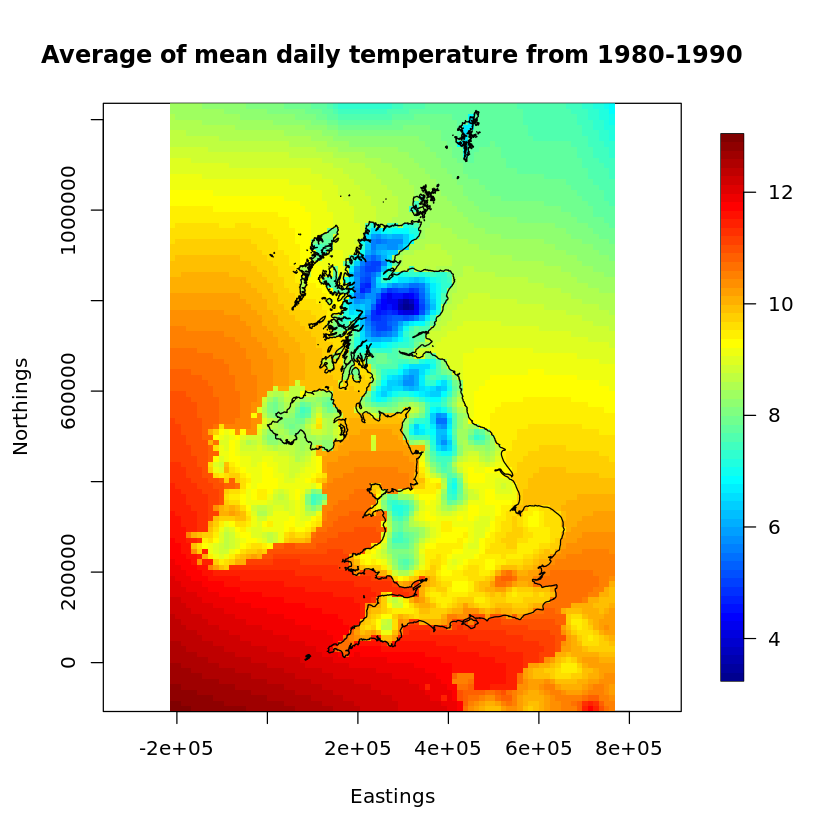

In [10]:
image.plot(x = as.integer(rownames(tas)), y = as.integer(colnames(tas)), deca.means[,,1], asp = T, 
           xlab = "Eastings", ylab = "Northings", main = "Average of mean daily temperature from 1980-1990")  
sp::plot(osgbmap, add = T)

We can also plot a map of the change in decadal mean temperatures:

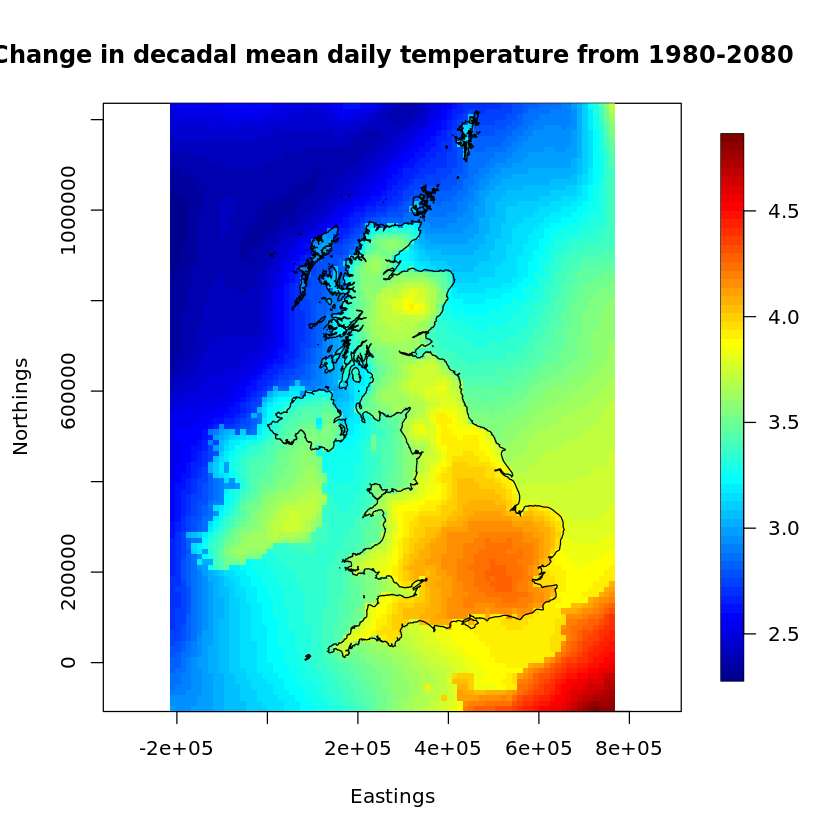

In [11]:
image.plot(x = as.integer(rownames(tas)), y = as.integer(colnames(tas)), deca.means[,,10] - deca.means[,,1], asp = T, 
           xlab = "Eastings", ylab = "Northings", main = "Change in decadal mean daily temperature from 1980-2080")  
sp::plot(osgbmap, add = T)

A lot of the detail is being obscured here because of the smaller change over the ocean - we can see the change over the UK and Ireland by applying a land-sea mask to blank out the oceans and France (sorry, France):

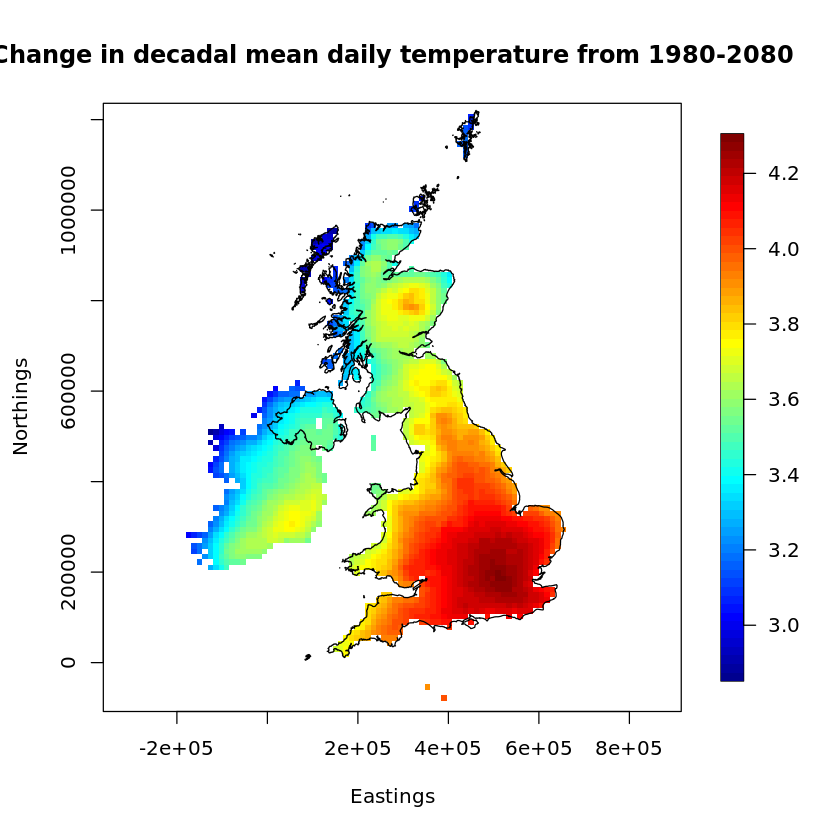

In [12]:
nc <- nc_open("~/UKCP18/ukcp-other/land-sea_mask_uk_12km.nc")
lsm <- ncvar_get(nc, "lsm")
nc_close(nc); remove(nc)

image.plot(x = as.integer(rownames(tas)), y = as.integer(colnames(tas)), (deca.means[,,10] - deca.means[,,1]) * lsm, asp = T, 
           xlab = "Eastings", ylab = "Northings", main = "Change in decadal mean daily temperature from 1980-2080")  
sp::plot(osgbmap, add = T)

We can also plot a time series of the decadal mean temperature at a particular grid cell:

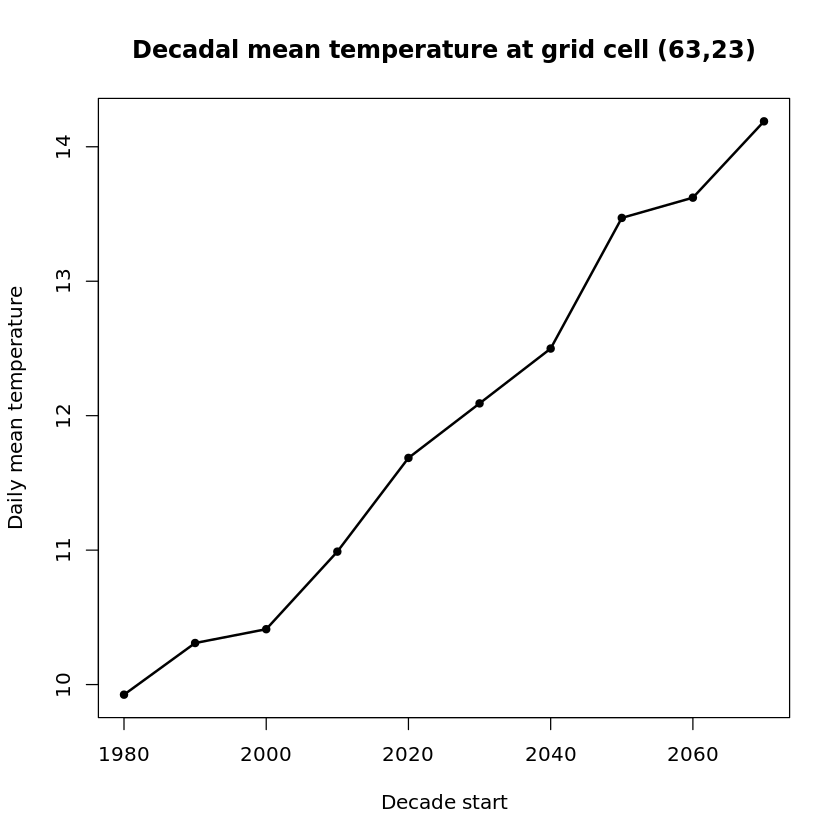

In [13]:
plot(seq(1980,2070,10), deca.means[63,23,], type = "o", lwd = 2, pch = 20, xlab = "Decade start", ylab = "Daily mean temperature",
    main = "Decadal mean temperature at grid cell (63,23)")

---

## **Plot smoothed monthly means**

The above time series with only 10 data points looks pretty stark. Instead we could plot the data for every month (which will have a lot of variability), and then plot a smoothed time series on top.

Instead of using the daily data, we can go straight to the monthly mean temperatures:

In [14]:
nc <- nc_open("~/UKCP18/mon/tas_rcp85_land-rcm_uk_12km_01_mon_198012-208011.nc")
tas <- ncvar_get(nc, "tas")
dimnames(tas)[[3]] <- substr(nc.get.time.series(nc, "tas"),1,10)
nc_close(nc)

This time, we'll use the land-sea mask to compute the monthly average temperature over the UK and Ireland:

In [15]:
# load the land-sea mask
nc <- nc_open("~/UKCP18/ukcp-other/land-sea_mask_uk_12km.nc")
lsm <- ncvar_get(nc, "lsm")
nc_close(nc)

# multiply each day's temperature data with the land-sea mask
tas.land <- sweep(tas, 1:2, lsm, "*")

# average the temperatures for each month - remember to remove the NA values over the ocean
tas.gridmean <- apply(tas.land, 3, mean, na.rm = T)

# compute the moving average
tas.gridmean.smoothed <- filter(tas.gridmean, rep(1,12)/12)

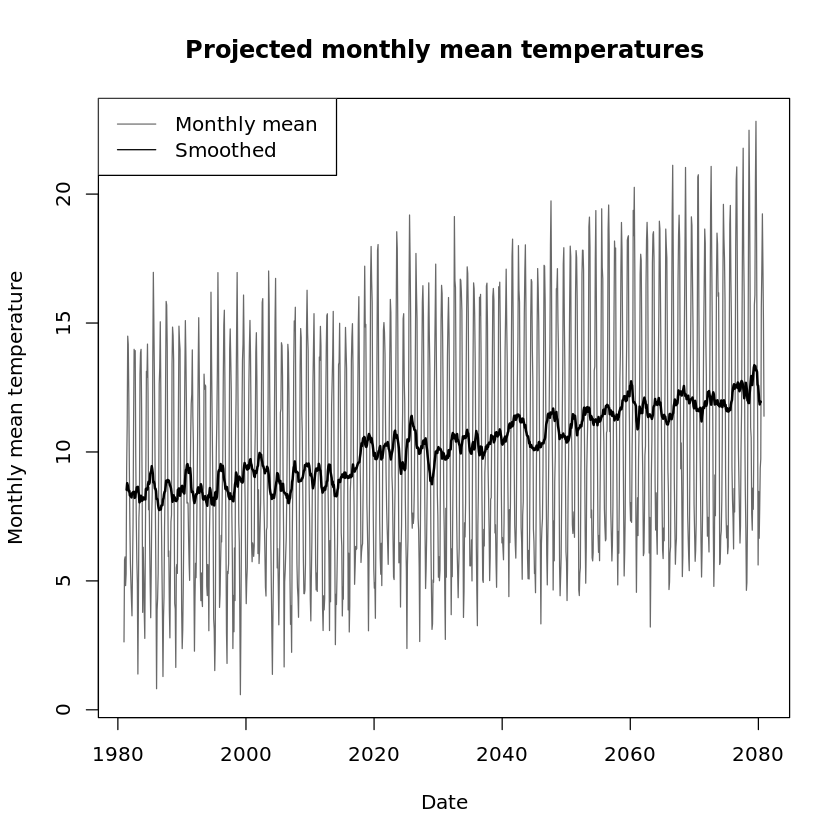

In [16]:
# plot
plot(as.Date(names(tas.gridmean)), tas.gridmean, type = "l", col = "dimgrey", xlab = "Date", ylab = "Monthly mean temperature",
     main = "Projected monthly mean temperatures")

lines(as.Date(names(tas.gridmean)), tas.gridmean.smoothed, lwd = 2)
legend("topleft", c("Monthly mean", "Smoothed"), lty = 1, col = c("dimgrey", "black"))

---

## **Compute some weather indices**

This data can be used to compute indices of specific aspects of the changing climate.  For example, the number of **tropical nights** each year is the number of occasions on which the minimum daily temperature `tasmin` remains above 20&deg;C. The minimum temperature typically occurs at around 3am, so is really a measure of the minimum overnight temperature.

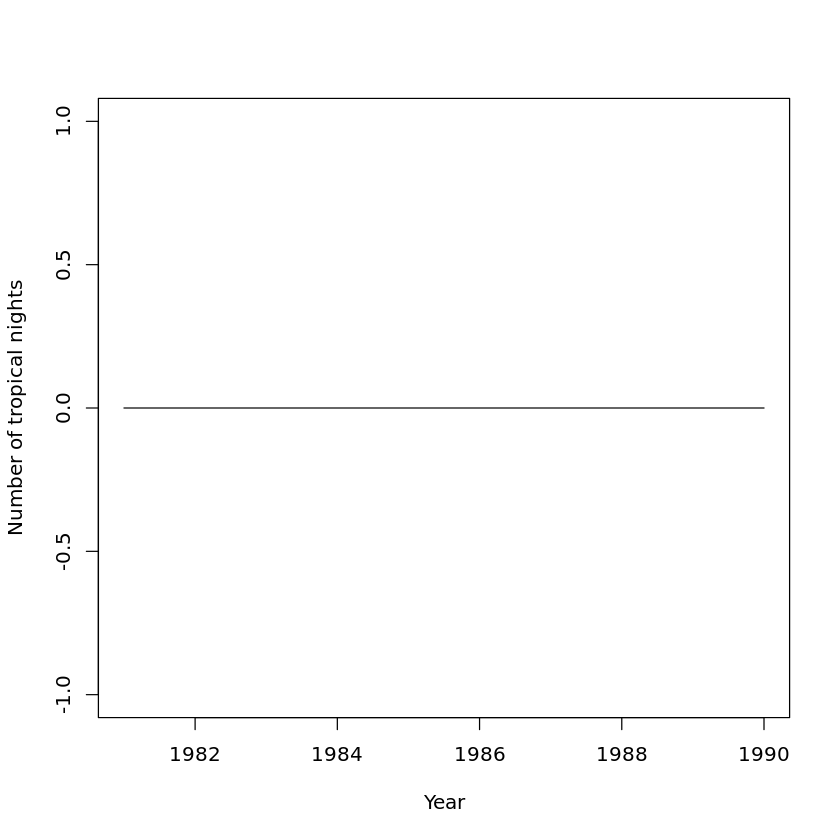

In [17]:
nc <- nc_open("~/UKCP18/day/tasmin_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc")
tasmin <- ncvar_get(nc, "tasmin")
dimnames(tasmin) <- list("E" = ncvar_get(nc, "projection_x_coordinate"),
                      "N" = ncvar_get(nc, "projection_y_coordinate"),
                      "date" = substr(nc.get.time.series(nc, "tasmin"),1,10))
nc_close(nc)

# create an indicator function to identify tropical nights
t.nights <- tasmin > 20

# because the model uses a 360-day calendar, we can index the years using a vector
years <- rep(1:10, each = 360)

# for each year, add up the number of tropical nights, and combine the results into a single array
tn.list <- lapply(1:10, function(y) apply(t.nights[,,years == y], 1:2, sum))
tn <- abind(tn.list, rev.along = 0)

# plot the number of tropical nights occurring in a particular grid cell in London
plot(1981:1990, tn[63,23,], type = "l", xlab = "Year", ylab = "Number of tropical nights")

Well, that's a little underwhelming. Let's apply the same code over all the daily temperature files and see what happens.

In [18]:
# loop over all the daily minimum temperature files
tasmin.files <- list.files("~/UKCP18/day", pattern = "tasmin", full.names = T)

tn.list <- lapply(tasmin.files, function(fnm) {
    
    # read the data
    nc <- nc_open(fnm)
    tasmin <- ncvar_get(nc, "tasmin")
    dimnames(tasmin) <- list("E" = ncvar_get(nc, "projection_x_coordinate"),
                             "N" = ncvar_get(nc, "projection_y_coordinate"),
                             "date" = substr(nc.get.time.series(nc, "tasmin"),1,10))
    nc_close(nc)
    
    # count the number of tropical nights each year
    t.nights <- tasmin > 20
    years <- rep(1:10, each = 360)
    tn <- abind(lapply(1:10, function(y) apply(t.nights[,,years == y], 1:2, sum)), rev.along = 0)
    return(tn)
})

# join the arrays together along the time axis
tn <- abind(tn.list, along = 3)


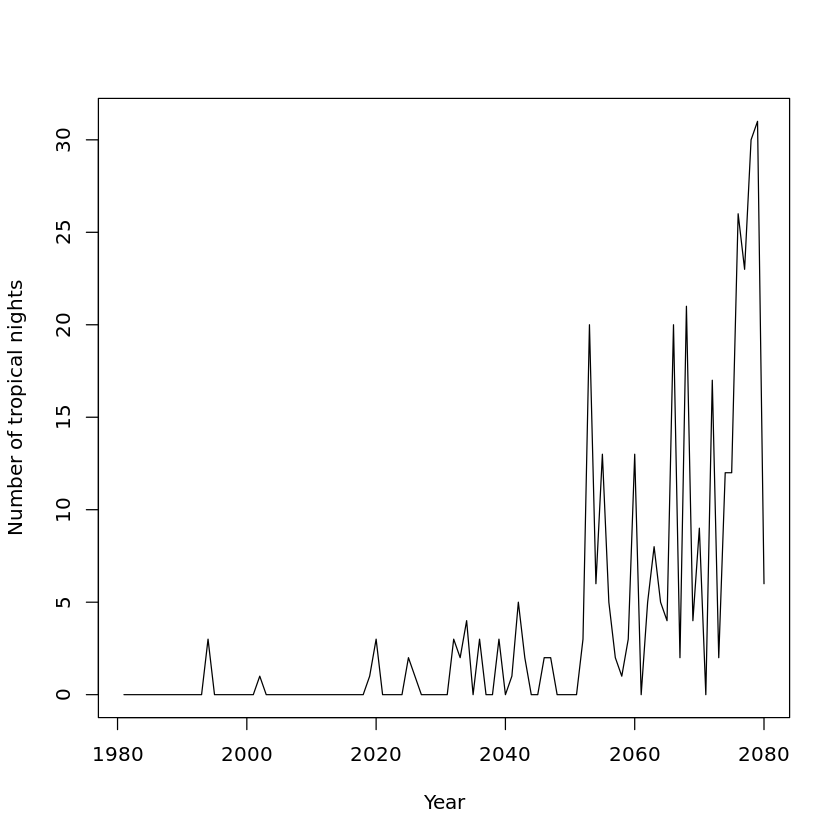

In [19]:
# plot the number of tropical nights occurring in a particular grid cell in London
plot(1981:2080, tn[63,23,], type = "l", xlab = "Year", ylab = "Number of tropical nights")

Finally, let's plot the time series of temperatures on the hottest day of each year. We can compress the code we used before into a single command:

In [ ]:
tx.max <- abind(lapply(list.files("~/UKCP18/day", pattern = "tasmax", full.names = T), function(fnm) {
    
    # read the data
    nc <- nc_open(fnm)
    tasmax <- ncvar_get(nc, "tasmax")
    dimnames(tasmax) <- list("E" = ncvar_get(nc, "projection_x_coordinate"),
                             "N" = ncvar_get(nc, "projection_y_coordinate"),
                             "date" = substr(nc.get.time.series(nc, "tasmax"),1,10))
    nc_close(nc)
    
    # for each year, extract the maximum temperature in each grid cell
    years <- rep(1:10, each = 360)
    tx <- abind(lapply(1:10, function(y) apply(tasmax[,,years == y], 1:2, max)), rev.along = 0)
    return(tx)
}), along = 3)

In [ ]:
# plot the maximum annual temperature in a particular grid cell in London
plot(1981:2080, tx.max[63,23,], type = "l", xlab = "Year", ylab = "Annual maximum temperature")